In [637]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Utils'), '..')))
from Utils.constants import DATASETS_FOLDER_PATH
from Utils.data_utils import load_preprocessed_data_from_folder

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Courses Packages
from Utils.DataVisualization import PlotConfusionMatrix, PlotLabelsHistogram, PlotBinaryClassData

# Model
from sklearn.naive_bayes import GaussianNB


# Load the data from the CSV file into a pandas DataFrame
data = load_preprocessed_data_from_folder()

# Separate features (X) and labels (y) from the loaded data
mX = data.drop(columns=["Potability"])  # Exclude the label column if it's included in the data
vY = data["Potability"]  # Extract the label column

# Now you can use X and y for further training

In [638]:
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000
mean,0.505674,0.539460,0.356824,0.530967,0.581304,0.427035,0.462428,0.532602,0.475862,0.500000
std,0.100570,0.117777,0.142869,0.121957,0.104295,0.139144,0.125323,0.125759,0.144602,0.500063
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.452602,0.469452,0.253668,0.455668,0.531806,0.323471,0.378677,0.455881,0.378720,0.000000
50%,0.504744,0.541045,0.338975,0.530720,0.581342,0.420177,0.458433,0.532614,0.473630,0.500000
75%,0.558737,0.612280,0.443251,0.606942,0.629772,0.523507,0.548002,0.613343,0.575194,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [639]:
# Parameters
lCriterion   = ['gini', 'entropy', 'log_loss'] #<! List
lMaxLeaf     = list(range(5, 11)) #<! List

# Data
numSamplesRatio = 0.2
NUM_FOLDS = 5

mXTrain, mXTest, vYTrain, vYTest = train_test_split(mX, vY, test_size = numSamplesRatio, shuffle = True, stratify = vY, random_state = 42)

In [640]:
# Train Test Split

print(f'The training features data shape: {mXTrain.shape}')
print(f'The training labels data shape: {vYTrain.shape}')
print(f'The test features data shape: {mXTest.shape}')
print(f'The test labels data shape: {vYTest.shape}')
print(f'The unique values of the labels: {np.unique(vY)}')

The training features data shape: (3196, 9)
The training labels data shape: (3196,)
The test features data shape: (800, 9)
The test labels data shape: (800,)
The unique values of the labels: [0. 1.]


## Classifier Model

Bootstrap Aggregating (Bagged) decision tree
Bagging involves training multiple decision trees on bootstrapped samples of the training data and then aggregating their predictions.  

### Naive Model

In [641]:
# Naive bagged decision tree model

oDecTreeCls = DecisionTreeClassifier()
oDecTreeCls.fit(mXTrain, vYTrain)

# Performance Train data
print(f'bagged decision tree train score: {oDecTreeCls.score(mXTrain, vYTrain):0.2%}')

# Performance data
scores = cross_val_score(oDecTreeCls, mX, vY, cv=NUM_FOLDS, scoring='f1')
print(f"Cross validation scores: {scores.mean():.2%}")


bagged decision tree train score: 100.00%
Cross validation scores: 63.25%


In [642]:
# Create Bagging classifier with current hyperparameters
bagging_classifier = BaggingClassifier(estimator=oDecTreeCls)
bagging_classifier.fit(mXTrain, vYTrain)

# Performance Train data
print(f'bagged decision tree train score: {bagging_classifier.score(mXTrain, vYTrain):0.2%}')

scores = cross_val_score(bagging_classifier, mX, vY, cv=NUM_FOLDS, scoring='f1')
print(f"Cross validation scores: {scores.mean():.2%}")

# Performance Test Data

vHatY = bagging_classifier.predict(mXTest)
vYGt  = vYTest

valAcc = np.mean(vHatY == vYGt)
valPrecision, valRecall, valF1, _ = precision_recall_fscore_support(vYGt, vHatY, pos_label = 1, average = 'binary')

# Create a single list containing values from all variables
test_data_scores_non_calibrated = [valAcc, valPrecision, valRecall, valF1]
print("Test scors:")
print(f'Accuracy  = {valAcc:0.2%}')
print(f'Precision = {valPrecision:0.2%}')
print(f'Recall    = {valRecall:0.2%}'   )
print(f'F1 Score  = {valF1:0.2%}'       )

bagged decision tree train score: 99.09%


Cross validation scores: 63.78%
Test scors:
Accuracy  = 67.12%
Precision = 69.41%
Recall    = 61.25%
F1 Score  = 65.07%


### Optimized DecisionTreeClassifier Model (Grid Search)

In [643]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

# Create the decision tree classifier
decTreeCls = DecisionTreeClassifier()

# Create GridSearchCV
grid_search = GridSearchCV(decTreeCls, param_grid, cv=NUM_FOLDS, scoring='f1', verbose=1)

# Fit the grid search to the data
grid_search.fit(mXTrain, vYTrain)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best F1 score:", best_score)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'criterion': 'gini', 'max_depth': 80}
Best F1 score: 0.6393299745886909


In [644]:
# Extract the Optimal Hyper Parameters

optimalCriterion = best_params['criterion']
optimalmax_depth  = best_params['max_depth']

print(f'The optimal hyper parameters are: `criterion` = {optimalCriterion}, `max_depth` = {optimalmax_depth}')


The optimal hyper parameters are: `criterion` = gini, `max_depth` = 80


In [645]:
# Define base decision tree classifier
oDecTreeCls = DecisionTreeClassifier(criterion = optimalCriterion, max_depth = optimalmax_depth)
# oDecTreeCls = DecisionTreeClassifier()
oDecTreeCls = oDecTreeCls.fit(mXTrain, vYTrain)

print(f'decision tree train score: {oDecTreeCls.score(mXTrain, vYTrain):0.2%}')
print(f'decision tree test score: {oDecTreeCls.score(mXTest, vYTest):0.2%}')

decision tree train score: 100.00%
decision tree test score: 63.75%


## Performa a manual search to graph the F1 score agains learning_rate


In [646]:
max_depths = range(1, 100 + 1)
scores_test = []
scores_train = []

for max_depth in max_depths:
  decision_tree = DecisionTreeClassifier(criterion = 'gini', max_depth=max_depth)
  decision_tree.fit(mXTrain, vYTrain)
  score_test = f1_score(vYTest, decision_tree.predict(mXTest))
  scores_test.append(score_test)
  score_train = f1_score(vYTrain, decision_tree.predict(mXTrain))
  scores_train.append(score_train)


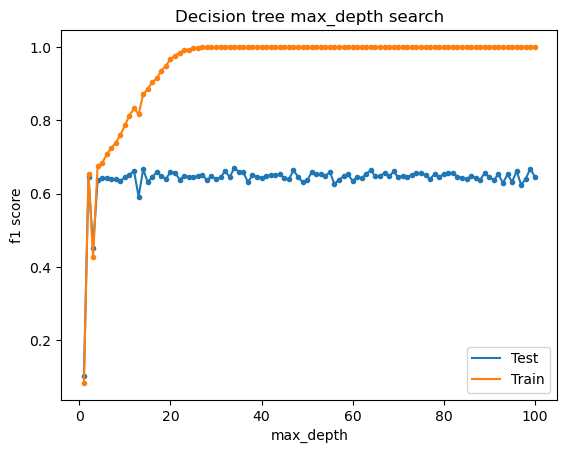

In [647]:
# Plot the search results

plt.plot(max_depths, scores_test, label='Test')
plt.scatter(max_depths, scores_test, marker='.')

# Add another plot (for example, train scores)
plt.plot(max_depths, scores_train, label='Train')
plt.scatter(max_depths, scores_train, marker='.')

plt.xlabel('max_depth')
plt.ylabel('f1 score')
plt.title('Decision tree max_depth search')
plt.legend()  # Add legend to distinguish between test and train scores

plt.show()


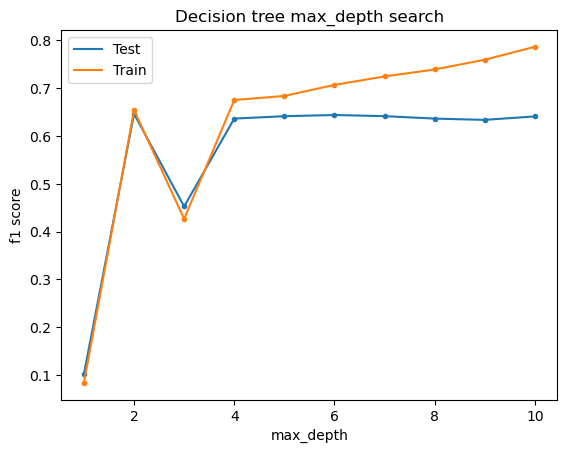

In [648]:
max_depths = range(1, 10 + 1)
scores_test = []
scores_train = []

for max_depth in max_depths:
  decision_tree = DecisionTreeClassifier(criterion = 'gini', max_depth=max_depth)
  decision_tree.fit(mXTrain, vYTrain)
  score_test = f1_score(vYTest, decision_tree.predict(mXTest))
  scores_test.append(score_test)
  score_train = f1_score(vYTrain, decision_tree.predict(mXTrain))
  scores_train.append(score_train)

# Plot the search results

plt.plot(max_depths, scores_test, label='Test')
plt.scatter(max_depths, scores_test, marker='.')

# Add another plot (for example, train scores)
plt.plot(max_depths, scores_train, label='Train')
plt.scatter(max_depths, scores_train, marker='.')

plt.xlabel('max_depth')
plt.ylabel('f1 score')
plt.title('Decision tree max_depth search')
plt.legend()  # Add legend to distinguish between test and train scores

plt.show()

### Choose non overfitting point

In [649]:
optimalmax_depth = 5
# Define base decision tree classifier
oDecTreeCls = DecisionTreeClassifier(criterion = optimalCriterion, max_depth = optimalmax_depth)
oDecTreeCls = oDecTreeCls.fit(mXTrain, vYTrain)

print(f'decision tree train score: {oDecTreeCls.score(mXTrain, vYTrain):0.2%}')
print(f'decision tree test score: {oDecTreeCls.score(mXTest, vYTest):0.2%}')

decision tree train score: 63.42%
decision tree test score: 59.00%


Accuracy  = 59.00%
Precision = 57.00%
Recall    = 73.25%
F1 Score  = 64.11%


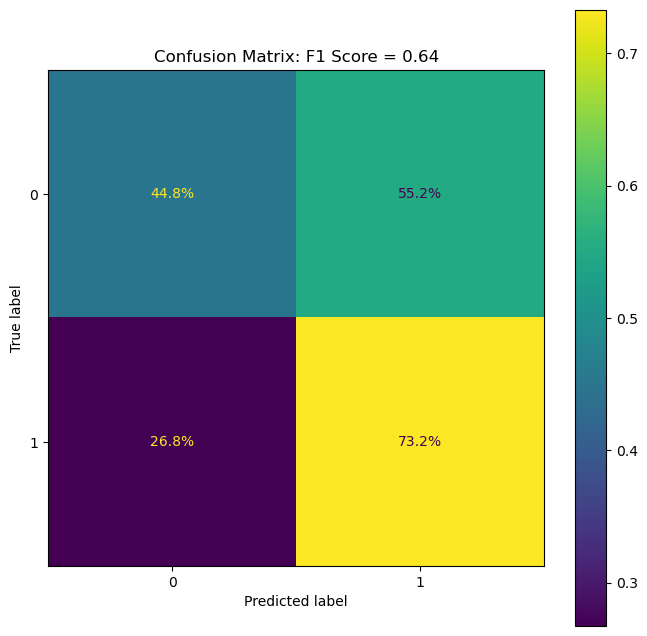

In [650]:
# Performance Test Data

vHatY = oDecTreeCls.predict(mXTest)
vYGt  = vYTest

valAcc = np.mean(vHatY == vYGt)
valPrecision, valRecall, valF1, _ = precision_recall_fscore_support(vYGt, vHatY, pos_label = 1, average = 'binary')

# Create a single list containing values from all variables
test_data_scores_non_calibrated = [valAcc, valPrecision, valRecall, valF1]

print(f'Accuracy  = {valAcc:0.2%}')
print(f'Precision = {valPrecision:0.2%}')
print(f'Recall    = {valRecall:0.2%}'   )
print(f'F1 Score  = {valF1:0.2%}'       )

dScore = {'F1 Score': valF1}

hF, hA = plt.subplots(figsize = (8, 8))
PlotConfusionMatrix(vYGt, vHatY, normMethod = 'true', hA = hA, dScore = dScore, valFormat = '0.1%') #<! The accuracy should be >= than above!
plt.show()

### Optimized Bagged Decision Tree Classifier Model (Grid Search)

In [651]:
# Define hyperparameter grid for bagging classifier
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}

# Create Bagging classifier with current hyperparameters
bagging_classifier = BaggingClassifier()

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=bagging_classifier, param_grid=param_grid, cv=NUM_FOLDS, scoring='f1', verbose=1)

# Fit the grid search to the data
grid_search.fit(mXTrain, vYTrain)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best F1 score:", best_score)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}
Best F1 score: 0.7151488486142239


In [652]:
# Define base decision tree classifier
final_bagging_classifier = BaggingClassifier(estimator=oDecTreeCls,
                                             n_estimators=best_params['n_estimators'],
                                             max_samples=best_params['max_samples'],
                                             max_features=best_params['max_features'])
# oDecTreeCls = DecisionTreeClassifier()
final_bagging_classifier = final_bagging_classifier.fit(mXTrain, vYTrain)

print(f'decision tree train score: {final_bagging_classifier.score(mXTrain, vYTrain):0.2%}')
print(f'decision tree test score: {final_bagging_classifier.score(mXTest, vYTest):0.2%}')

decision tree train score: 69.24%
decision tree test score: 61.38%


Accuracy  = 61.38%
Precision = 59.70%
Recall    = 70.00%
F1 Score  = 64.44%


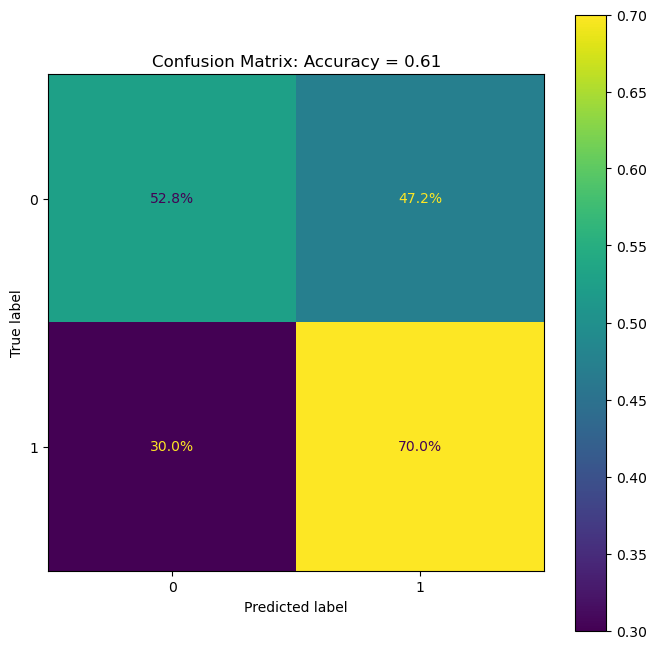

In [653]:
# Performance Test Data
vHatY = final_bagging_classifier.predict(mXTest)
vYGt  = vYTest

valAcc = np.mean(vHatY == vYGt)
valPrecision, valRecall, valF1, _ = precision_recall_fscore_support(vYGt, vHatY, pos_label = 1, average = 'binary')

# Create a single list containing values from all variables
test_data_scores_non_calibrated = [valAcc, valPrecision, valRecall, valF1]

print(f'Accuracy  = {valAcc:0.2%}')
print(f'Precision = {valPrecision:0.2%}')
print(f'Recall    = {valRecall:0.2%}'   )
print(f'F1 Score  = {valF1:0.2%}'       )

dScore = {'Accuracy': valAcc}

hF, hA = plt.subplots(figsize = (8, 8))
PlotConfusionMatrix(vYGt, vHatY, normMethod = 'true', hA = hA, dScore = dScore, valFormat = '0.1%') #<! The accuracy should be >= than above!
plt.show()

## Probability calibration

In [654]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Use the calibrated classifier to predict probabilities on the test data
prob_pos = final_bagging_classifier.predict_proba(mXTest)[:, 1]

# Compute true and predicted probabilities for the positive class
true_prob_non_calibrated, pred_prob_non_calibrated = calibration_curve(vYTest, prob_pos, n_bins=10)

In [655]:
from sklearn.calibration import CalibratedClassifierCV

# Create CalibratedClassifierCV with isotonic calibration
calibrated_classifier = CalibratedClassifierCV(final_bagging_classifier, method='isotonic', cv='prefit')

# Fit the calibrated classifier to your training data
calibrated_classifier.fit(mXTrain, vYTrain)

# Make predictions on your test data
y_pred = calibrated_classifier.predict(mXTest)

Accuracy  = 62.88%
Precision = 63.04%
Recall    = 62.25%
F1 Score  = 62.64%


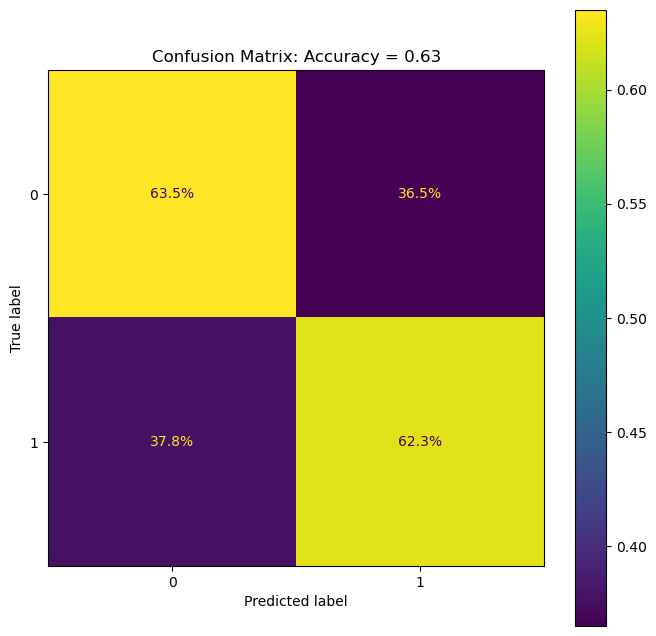

In [656]:
# Performance Test Data

vHatY = calibrated_classifier.predict(mXTest)
vYGt  = vYTest

valAcc = np.mean(vHatY == vYGt)
valPrecision, valRecall, valF1, _ = precision_recall_fscore_support(vYGt, vHatY, pos_label = 1, average = 'binary')

# Create a single list containing values from all variables
test_data_scores_calibrated = [valAcc, valPrecision, valRecall, valF1]

print(f'Accuracy  = {valAcc:0.2%}')
print(f'Precision = {valPrecision:0.2%}')
print(f'Recall    = {valRecall:0.2%}'   )
print(f'F1 Score  = {valF1:0.2%}'       )

dScore = {'Accuracy': valAcc}

hF, hA = plt.subplots(figsize = (8, 8))
PlotConfusionMatrix(vYGt, vHatY, normMethod = 'true', hA = hA, dScore = dScore, valFormat = '0.1%') #<! The accuracy should be >= than above!
plt.show()

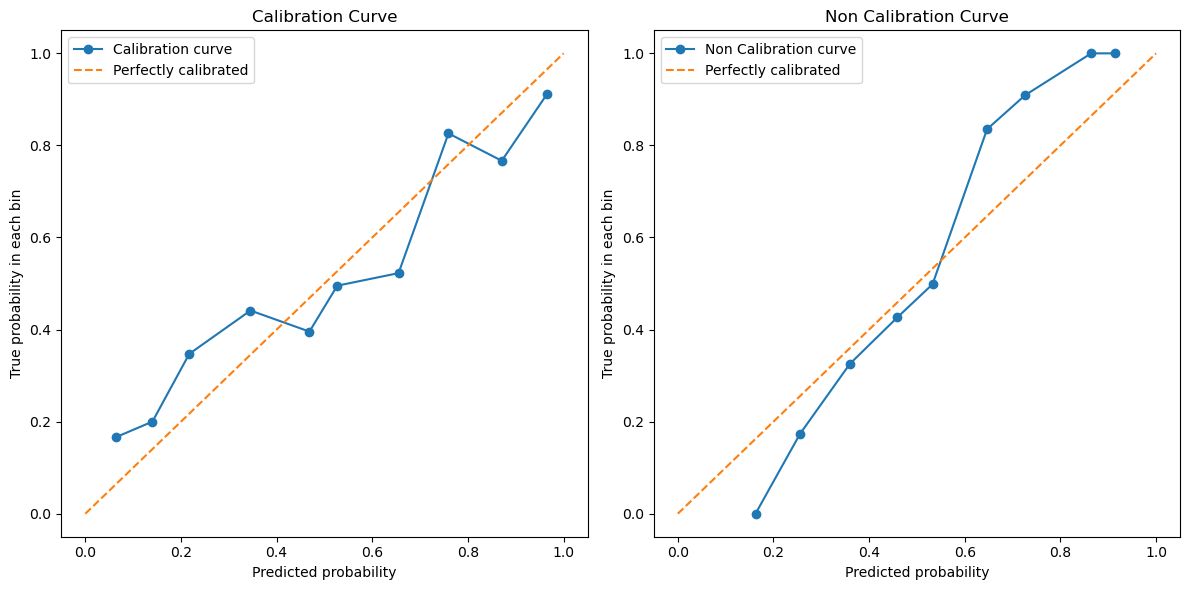

In [657]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Use the calibrated classifier to predict probabilities on the test data
prob_pos = calibrated_classifier.predict_proba(mXTest)[:, 1]

# Compute true and predicted probabilities for the positive class
true_prob, pred_prob = calibration_curve(vYTest, prob_pos, n_bins=10)

# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the calibration curve in the first subplot
ax1.plot(pred_prob, true_prob, marker='o', label='Calibration curve')
ax1.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
ax1.set_xlabel('Predicted probability')
ax1.set_ylabel('True probability in each bin')
ax1.set_title('Calibration Curve')
ax1.legend()

# Plot the additional curve in the second subplot
# Replace these lines with your code to plot the additional curve
ax2.plot(pred_prob_non_calibrated, true_prob_non_calibrated, marker='o', label='Non Calibration curve')
ax2.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
ax2.set_xlabel('Predicted probability')
ax2.set_ylabel('True probability in each bin')
ax2.set_title('Non Calibration Curve')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


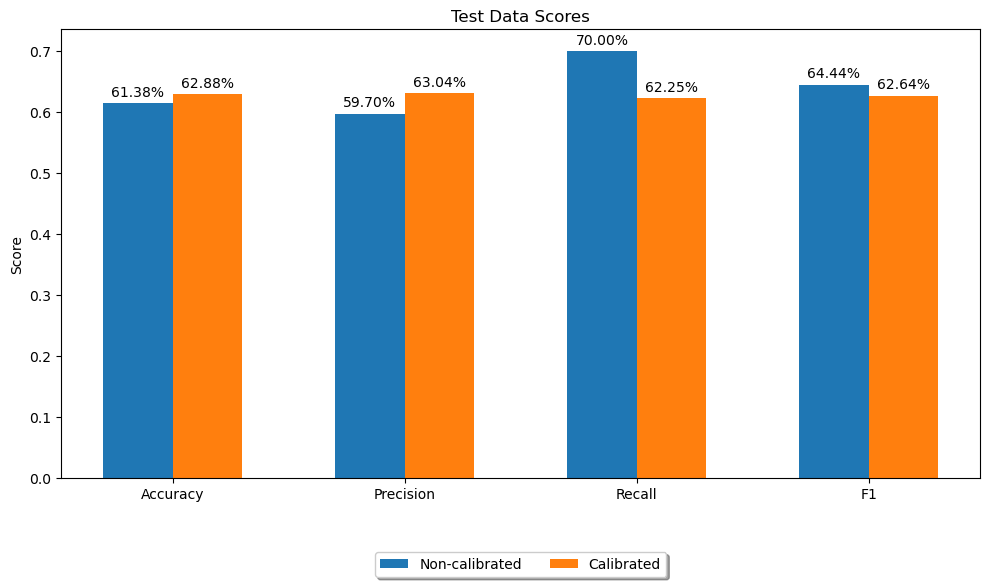

In [658]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the width of the bars
bar_width = 0.3

# Set the x locations for the groups
index = np.arange(len(test_data_scores_non_calibrated))

# Plot test data scores
fig, ax = plt.subplots(figsize=(10, 6))  # Only one subplot

# Test data scores
ax.bar(index - bar_width/2, test_data_scores_non_calibrated, bar_width, label='Non-calibrated')
ax.bar(index + bar_width/2, test_data_scores_calibrated, bar_width, label='Calibrated')
ax.set_title('Test Data Scores')
ax.set_xticks(index)
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1'])
ax.set_ylabel('Score')
ax.legend()

# Function to add percentage labels to the bars
def add_percentage_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.2f}%'.format(height * 100),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add percentage labels to the bars
add_percentage_labels(ax, ax.patches)

# Move the legend outside of the graph
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

plt.tight_layout()
plt.show()

